In [1]:
import stim
d = 5
r = 2
circuit = stim.Circuit.generated(
    "surface_code:rotated_memory_z",
    rounds=2,
    distance=d,
    before_round_data_depolarization=0.001,
)
import os
# write to surface_d2.stim
with open(os.path.join(os.getcwd(), f"surface_d{d}r{r}.stim"), "w") as f:
    f.write(str(circuit))

In [2]:
import os

# load surface_d2.stim
with open(os.path.join(os.getcwd(), f"surface_d{d}r{r}.stim")) as f:
    circuit = stim.Circuit(f.read())


In [3]:
def gen_normal_circuit(d, r):
    return stim.Circuit.generated(
        "surface_code:rotated_memory_z",
        rounds=r,
        distance=d,
        before_round_data_depolarization=0.001,
    )

Gonna split this code in half

* duplicate the check qubits in the center line
* make the stabilizers only connect to the data qubits on their side
* make new detectors for the new check qubits right next to the old detectors
* figure out the ending detectors
* compare this code to a normal distance 2 code

in the future
* each new stabilizer gets its own detector
* modify pymatching to account for this
* keep the border stabilizer

In [6]:
qubits = circuit.get_final_qubit_coordinates()
qubits

{1: [1.0, 1.0],
 2: [2.0, 0.0],
 3: [3.0, 1.0],
 5: [5.0, 1.0],
 8: [1.0, 3.0],
 9: [2.0, 2.0],
 10: [3.0, 3.0],
 11: [4.0, 2.0],
 12: [5.0, 3.0],
 13: [6.0, 2.0],
 14: [0.0, 4.0],
 15: [1.0, 5.0],
 16: [2.0, 4.0],
 17: [3.0, 5.0],
 18: [4.0, 4.0],
 19: [5.0, 5.0],
 25: [4.0, 6.0]}

In [7]:
coords_to_qubits = {(x, y): i for i, [x, y] in qubits.items()}
coords_to_qubits

{(1.0, 1.0): 1,
 (2.0, 0.0): 2,
 (3.0, 1.0): 3,
 (5.0, 1.0): 5,
 (1.0, 3.0): 8,
 (2.0, 2.0): 9,
 (3.0, 3.0): 10,
 (4.0, 2.0): 11,
 (5.0, 3.0): 12,
 (6.0, 2.0): 13,
 (0.0, 4.0): 14,
 (1.0, 5.0): 15,
 (2.0, 4.0): 16,
 (3.0, 5.0): 17,
 (4.0, 4.0): 18,
 (5.0, 5.0): 19,
 (4.0, 6.0): 25}

# Center qubits (wrong)

In [26]:
center_qubits = [i for i in qubits if qubits[i][0] == 3]
center_qubits

[3, 10, 17]

In [27]:
const = 1000
# these will be on the right side
duped_center_qubits = {i+const: (qubits[i][0]+0.1, qubits[i][1]+0.1) for i in center_qubits}

# these will be on the left side
for i in center_qubits:
    qubits[i] = (qubits[i][0]-0.1, qubits[i][1]-0.1)

qubits.update(duped_center_qubits)
qubits

{1: [1.0, 1.0],
 2: [2.0, 0.0],
 3: (2.9, 0.9),
 5: [5.0, 1.0],
 8: [1.0, 3.0],
 9: [2.0, 2.0],
 10: (2.9, 2.9),
 11: [4.0, 2.0],
 12: [5.0, 3.0],
 13: [6.0, 2.0],
 14: [0.0, 4.0],
 15: [1.0, 5.0],
 16: [2.0, 4.0],
 17: (2.9, 4.9),
 18: [4.0, 4.0],
 19: [5.0, 5.0],
 25: [4.0, 6.0],
 1003: (3.1, 1.1),
 1010: (3.1, 3.1),
 1017: (3.1, 5.1)}

In [ ]:
new_ops = []

# get all the cnot gates
for op in circuit:
    if op.name == "CX":
        gates = op.targets_copy()
        pairs = []
        for i in range(0, len(gates), 2):
            # print(gates[i].qubit_value)
            pairs.append([gates[i].qubit_value, gates[i+1].qubit_value])
        
        new_pairs = []
        for control, target in pairs:
            pair = (control, target)
            if control in center_qubits:
                if qubits[target][0] > 3:
                    # target is to the right
                    # so we instead replace control with the duped control
                    pair = (control+const, target)
            
            if target in center_qubits:
                if qubits[control][0] > 3:
                    # control is to the right
                    # so we instead replace the target with the duped target
                    pair = (control, target+const)
            
            new_pairs.append(pair)
        
        new_targets = [x for y in new_pairs for x in y]
        # make operation out of the new pairs
        new_op = stim.CircuitInstruction(op.name, new_targets)
        new_ops.append(new_ops)


[[2, 3], [16, 17], [11, 12], [15, 14], [10, 9], [19, 18]]
[(2, 3), (16, 17), (11, 12), (15, 14), (10, 9), (19, 18)]
[[2, 1], [16, 15], [11, 10], [8, 14], [3, 9], [12, 18]]
[(2, 1), (16, 15), (11, 1010), (8, 14), (3, 9), (12, 18)]
[[16, 10], [11, 5], [25, 19], [8, 9], [17, 18], [12, 13]]
[(16, 10), (11, 5), (25, 19), (8, 9), (1017, 18), (12, 13)]
[[16, 8], [11, 3], [25, 17], [1, 9], [10, 18], [5, 13]]
[(16, 8), (11, 1003), (25, 1017), (1, 9), (1010, 18), (5, 13)]
[[2, 3], [16, 17], [11, 12], [15, 14], [10, 9], [19, 18]]
[(2, 3), (16, 17), (11, 12), (15, 14), (10, 9), (19, 18)]
[[2, 1], [16, 15], [11, 10], [8, 14], [3, 9], [12, 18]]
[(2, 1), (16, 15), (11, 1010), (8, 14), (3, 9), (12, 18)]
[[16, 10], [11, 5], [25, 19], [8, 9], [17, 18], [12, 13]]
[(16, 10), (11, 5), (25, 19), (8, 9), (1017, 18), (12, 13)]
[[16, 8], [11, 3], [25, 17], [1, 9], [10, 18], [5, 13]]
[(16, 8), (11, 1003), (25, 1017), (1, 9), (1010, 18), (5, 13)]


# Center check qubits

In [9]:
def gen_cut_circuit(d, r, offset=1, const=1000):
    import stim
    circuit = stim.Circuit.generated(
        "surface_code:rotated_memory_z",
        rounds=r,
        distance=d,
        # before_round_data_depolarization=0.001,
    )

    qubits = circuit.get_final_qubit_coordinates()

    center_line = d + 1
    center_qubits = [i for i in qubits if qubits[i][0] == center_line]
    center_qubits = [center_qubits[2]]  # only cut one qubit for now
    print("Center qubits:", center_qubits)

    # const = len(qubits)+1
    # print(const)
    
    # these will be on the right side
    duped_center_qubits = {i+const: (qubits[i][0]+offset, qubits[i][1]+offset) for i in center_qubits}

    # these will be on the left side
    for i in center_qubits:
        qubits[i] = (qubits[i][0]-offset, qubits[i][1]-offset)

    qubits.update(duped_center_qubits)

    new_ops = []
    old_record = []
    new_record = []
    # get all the ops
    for op in circuit:
        if op.name == "CX":
            gates = op.targets_copy()
            pairs = []
            for i in range(0, len(gates), 2):
                pairs.append([gates[i].qubit_value, gates[i+1].qubit_value])
            
            new_pairs = []
            for control, target in pairs:
                pair = (control, target)
                if control in center_qubits:
                    if qubits[target][0] > center_line:
                        # target is to the right
                        # so we instead replace control with the duped control
                        pair = (control+const, target)
                
                if target in center_qubits:
                    if qubits[control][0] > center_line:
                        # control is to the right
                        # so we instead replace the target with the duped target
                        pair = (control, target+const)
                
                new_pairs.append(pair)
            
            new_targets = [x for y in new_pairs for x in y]
            # make instruction out of the new targets
            new_op = stim.CircuitInstruction(op.name, new_targets)
            new_ops.append(new_op)
        elif op.name in ["DETECTOR", "OBSERVABLE_INCLUDE"]:
            # figure out the new order of the record
            targets = op.targets_copy()
            # new_targets = []
            left_targets = []
            right_targets = []
            center_targets = []
            combined = False
            i = len(new_record)
            for t in targets:
                # figure out the correct index in the new record
                # find last occurrence of old_record[t.value]
                # assume targets are always in ascending order (MIGHT NOT ALWAYS BE TRUE, FIX LATER)
                index = i - new_record[i-1::-1].index(old_record[t.value]) - 1
                new_index = index - len(new_record)
                assert new_record[new_index] == old_record[t.value]
                i = index 
                if old_record[t.value] in center_qubits:
                    center_targets.append(stim.target_rec(new_index))
                elif qubits[old_record[t.value]][0] < center_line:
                    left_targets.append(stim.target_rec(new_index))
                elif qubits[old_record[t.value]][0] > center_line:
                    right_targets.append(stim.target_rec(new_index))
                else:
                    # on center line but we're not duping it
                    combined = True

                # new_targets.append(stim.target_rec(new_index))
                # if old_record[t.value] in center_qubits:
                #     # add the duped qubit second (the index is always the next one)
                #     new_targets.append(stim.target_rec(new_index+1))
            # new_op = stim.CircuitInstruction(op.name, new_targets, op.gate_args_copy())
            # new_ops.append(new_op)
            if combined:
                new_targets = left_targets + right_targets
                new_op = stim.CircuitInstruction(op.name, new_targets, op.gate_args_copy())
                new_ops.append(new_op)
                print("targets", targets)
                print("Combined detector/observable:", new_op, left_targets, right_targets, center_targets)
            else:
                if len(left_targets) == 0 and len(right_targets) > 0:
                    for t in center_targets:
                        right_targets.append(stim.target_rec(t.value+1))
                elif len(right_targets) == 0 and len(left_targets) > 0:
                    for t in center_targets:
                        left_targets.append(stim.target_rec(t.value))
                else:
                    left_targets += center_targets
                    right_targets += [stim.target_rec(t.value+1) for t in center_targets]
                # print("targets:", [old_record[t.value] for t in targets])
                # print("left:", [new_record[t.value] for t in left_targets])
                # print("right:", [new_record[t.value] for t in right_targets])
                # print("=========")
                if len(left_targets) > 0:
                    left_op = stim.CircuitInstruction(op.name, left_targets, op.gate_args_copy())
                    new_ops.append(left_op)
                if len(right_targets) > 0:
                    right_op = stim.CircuitInstruction(op.name, right_targets, op.gate_args_copy())
                    new_ops.append(right_op)
        elif op.name in ["TICK", "REPEAT"]:
            # nothing to do here
            new_ops.append(op)
        elif op.name in ["QUBIT_COORDS"]:
            # make new qubit coords
            coords = op.gate_args_copy()
            qubit = op.targets_copy()[0].qubit_value
            if qubit in center_qubits:
                # new_coords = [x + offset for x in coords]
                new_coords = [coords[0]+offset, coords[1]]
                coords[0] -= offset
                # coords[1] -= 0.1
                new_op2 = stim.CircuitInstruction(op.name, [qubit+const], new_coords)
                new_ops.append(new_op2)
            new_op = stim.CircuitInstruction(op.name, [qubit], coords)
            new_ops.append(new_op)
        elif op.name in ["R", "X", "Y", "Z", "H", "M", "MR"]:
            new_targets = []
            for t in op.targets_copy():
                if op.name in ["M", "MR"]:
                    old_record.append(t.qubit_value)
                    new_record.append(t.qubit_value)
                    if t.qubit_value in center_qubits:
                        new_record.append(t.qubit_value + const)
                new_targets.append(t.qubit_value)
                if t.qubit_value in center_qubits:
                    new_targets.append(t.qubit_value + const)
            new_op = stim.CircuitInstruction(op.name, new_targets)
            new_ops.append(new_op)
        elif op.name in ["DEPOLARIZE1"]:
            new_targets = []
            for t in op.targets_copy():
                new_targets.append(t.qubit_value)
                if t.qubit_value in center_qubits:
                    new_targets.append(t.qubit_value + const)
            new_op = stim.CircuitInstruction(op.name, new_targets, op.gate_args_copy())
            new_ops.append(new_op)
        elif op.name in ["DEPOLARIZE2"]:
            new_targets = []
            targets = op.targets_copy()
            pairs = []
            for i in range(0, len(targets), 2):
                pairs.append((targets[i].qubit_value, targets[i+1].qubit_value))
            for c, t in pairs:
                new_targets.append(c)
                new_targets.append(t)
                if c in center_qubits:
                    new_targets.append(c + const)
                    new_targets.append(t)
                if t in center_qubits:
                    new_targets.append(c)
                    new_targets.append(t + const)
            new_op = stim.CircuitInstruction(op.name, new_targets, op.gate_args_copy())
            new_ops.append(new_op)
        elif op.name in ["SHIFT_COORDS"]:
            new_ops.append(op)
        # ignore other operations for now
        else:
            print(f"Unknown operation: {op}")
            new_ops.append(op)

    new_circuit = stim.Circuit()
    for op in new_ops:
        new_circuit.append(op)
    return new_circuit


Center qubits: [28]
targets [stim.target_rec(-20)]
Combined detector/observable: DETECTOR(6, 2, 0) [] [] []
targets [stim.target_rec(-10)]
Combined detector/observable: DETECTOR(6, 6, 0) [] [] []
targets [stim.target_rec(-23), stim.target_rec(-47)]
Combined detector/observable: DETECTOR(6, 0, 0) [] [] []
targets [stim.target_rec(-20), stim.target_rec(-44)]
Combined detector/observable: DETECTOR(6, 2, 0) [] [] []
targets [stim.target_rec(-10), stim.target_rec(-34)]
Combined detector/observable: DETECTOR(6, 6, 0) [] [] []
targets [stim.target_rec(-4), stim.target_rec(-28)]
Combined detector/observable: DETECTOR(6, 8, 0) [] [] []
targets [stim.target_rec(-17), stim.target_rec(-18), stim.target_rec(-22), stim.target_rec(-23), stim.target_rec(-45)]
Combined detector/observable: DETECTOR(6, 2, 1) rec[-18] rec[-23] rec[-17] rec[-22] [stim.target_rec(-18), stim.target_rec(-23)] [stim.target_rec(-17), stim.target_rec(-22)] []
targets [stim.target_rec(-7), stim.target_rec(-8), stim.target_rec(-1

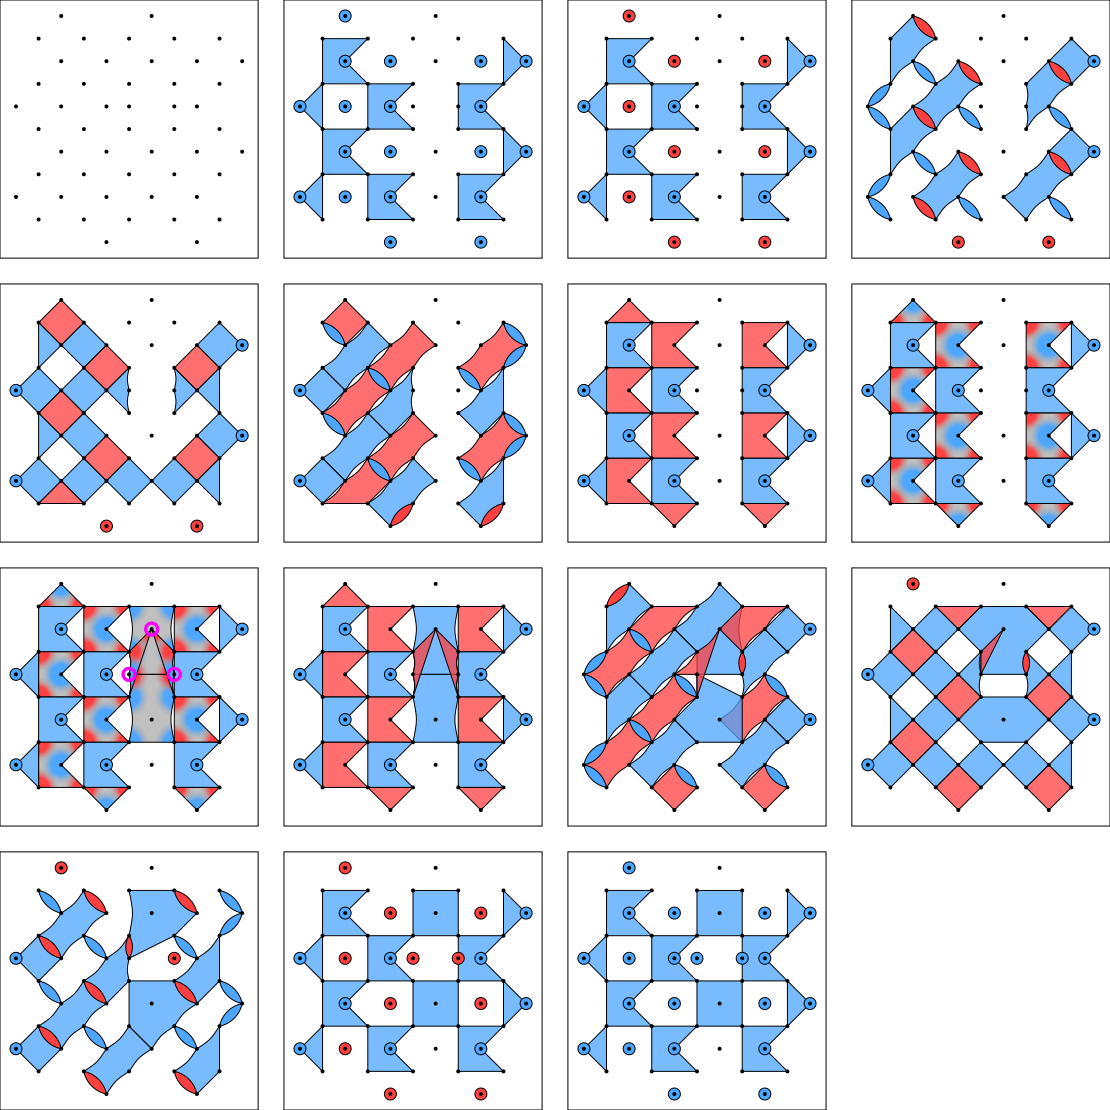

In [10]:
# new_circuit = stim.Circuit()
# for op in new_ops:
#     new_circuit.append(op)
new_circuit = gen_cut_circuit(5, 2, const=1000)
# # new_circuit.diagram("timeslice-svg")
new_circuit.diagram("detslice-svg")
# new_circuit.diagram("detslice-with-ops-svg")

In [30]:
print(new_circuit)

QUBIT_COORDS(1, 1) 1
QUBIT_COORDS(2, 0) 2
QUBIT_COORDS(3, 1) 3
QUBIT_COORDS(5, 1) 5
QUBIT_COORDS(1, 3) 8
QUBIT_COORDS(2, 2) 9
QUBIT_COORDS(3, 3) 10
QUBIT_COORDS(5, 2) 1011
QUBIT_COORDS(3, 2) 11
QUBIT_COORDS(5, 3) 12
QUBIT_COORDS(6, 2) 13
QUBIT_COORDS(0, 4) 14
QUBIT_COORDS(1, 5) 15
QUBIT_COORDS(2, 4) 16
QUBIT_COORDS(3, 5) 17
QUBIT_COORDS(4, 4) 18
QUBIT_COORDS(5, 5) 19
QUBIT_COORDS(4, 6) 25
R 1 3 5 8 10 12 15 17 19 2 9 11 1011 13 14 16 18 25
TICK
H 2 11 1011 16 25
TICK
CX 2 3 16 17 1011 12 15 14 10 9 19 18
TICK
CX 2 1 16 15 11 10 8 14 3 9 12 18
TICK
CX 16 10 1011 5 25 19 8 9 17 18 12 13
TICK
CX 16 8 11 3 25 17 1 9 10 18 5 13
TICK
H 2 11 1011 16 25
TICK
MR 2 9 11 1011 13 14 16 18 25
DETECTOR(0, 4, 0) rec[-4]
DETECTOR(2, 2, 0) rec[-8]
DETECTOR(4, 4, 0)
DETECTOR(6, 2, 0) rec[-5]
TICK
H 2 11 1011 16 25
TICK
CX 2 3 16 17 1011 12 15 14 10 9 19 18
TICK
CX 2 1 16 15 11 10 8 14 3 9 12 18
TICK
CX 16 10 1011 5 25 19 8 9 17 18 12 13
TICK
CX 16 8 11 3 25 17 1 9 10 18 5 13
TICK
H 2 11 1011 16 25
TICK


<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <title>Crumble</title>
    <link rel="shortcut icon" href="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAACAAAAAgCAYAAABzenr0AAABgWlDQ1BJQ0MgcHJvZmlsZQAAKJF9kTlIA0EUhj+j4kHEwhQiFluolQFREUuNgggRQlTwKtzdnJBdw27ExlKwDVh4NF6FjbW2FraCIHiAWFpZKdpIWN8kgQQxDgzz8c/8j/f+Ad9RxrTchgGw7JwTnQppC4tLWtMrrfiAAC266WbHI5EwNdfXPXXqvAuqWrXf/bnaYnHXhDpNeMzMOjnhVeGRjVxW8Z7qwkzpMeFz4X5HGhR+VLpR4jfFySKrpgk4c9EJ4YCwlqxio4rNlGMJDwv3xCxb6vsWShxTvKnYyqyb5T7VhP64PT+rdNndTDHNDBE0DNZJkyFHUE5bFJeo3Idq+LuK/oi4DHGlMcUxyRoWetGP+oPf2bqJocFSJX8IGl8876MXmnagkPe872PPK5xA/TNc2RX/2hGMfoqer2g9h9C+BRfXFc3Yhctt6HzK6o5elOpl+xIJeD+Tb1qEjltoXS7lVr7n9AHmJKvwDewfQF9Saq/UmLu5Ord/35Tz+wHVp3JoxsjWZAAAAAlwSFlzAAAuIwAALiMBeKU/dgAAAAd0SU1FB+YKAhYQLxXIct8AAAAZdEVYdENvbW1lbnQAQ3JlYXRlZCB3aXRoIEdJTVBXgQ4XAAAAx0lEQVRYw+2XwQ7EIAhEB+N/E76cnkgIa6OuWTFxvTWxdRgKDwmAYu+i+KDKPP62CJjHNYsQ7Psk8iGk7AxdmeGC1e0CvBBbKQK8ljQB5kK2AxcLsJLMdoBKZvQAULMOtk5IR7Dg294+yw4RymUBs3qQ5bHAO34vC8yFPwvSBFhJ3skC35Bq1sHHsKDGKfUX94J46HllGDjd5XnI5WjOXwXQSg5X95eXaaU3zXSjG3XJ79LW1ak1RsX9/qdsldqsPTppo66k6QGRuElWZ7d4CQAAAABJRU5ErkJggg==">
</head>
<style>
    table tr {
        border: 1px solid black;
    }
    table td {
        border: 1px solid black;
        padding-left: 5px;
        padding-right: 5px;
    }
    table th {
        border: 1px solid black;
        padding-left: 5px;
        padding-right: 5px;
    }
</style>
<body style="margin: 0">
    <div style="display: inline-block">
        <div>
            <div style="display: inline-block">
                Crumble is a prototype stabilizer circuit editor.<br>
                <br>
                <a href="https://github.com/quantumlib/Stim/blob/main/glue/crumble/README.md">Read the manual</a>
                <br>
                <br>
                <button id="btnShowExamples">Show Example Circuits</button><br>
                <br>
            </div>
            <div style="display: inline-block">
                <canvas id="toolbox" style="width: 370px; height: 110px; border: 1px solid black; margin: 0; padding: 0;">
                </canvas>
            </div>
            <div id='examples-div' style="border: 1px solid black; margin: 10px; display: none; width: fit-content">
                <strong>Example Circuits</strong>
                <table style="border: 1px solid black; margin: 10px; text-align: left; border-collapse: collapse;">
                    <thead>
                        <tr>
                            <th scope="col">Code</th>
                            <th scope="col">Style</th>
                            <th scope="col">Task</th>
                            <th scope="col">Size</th>
                            <th scope="col">Link</th>
                        </tr>
                    </thead>
                    <tbody>
                        <tr>
                            <td>Bacon-Shor Code</td>
                            <td>Interleaved (XZXZ)</td>
                            <td>Memory (H)</td>
                            <td>5x5x3</td>
                            <td><a href="
                                #circuit=Q(0,0)0;Q(0,1)1;Q(0,2)2;Q(0,3)3;Q(0,4)4;Q(1,0)5;Q(1,1)6;Q(1,2)7;Q(1,3)8;Q(1,4)9;Q(2,0)10;Q(2,1)11;Q(2,2)12;Q(2,3)13;Q(2,4)14;Q(3,0)15;Q(3,1)16;Q(3,2)17;Q(3,3)18;Q(3,4)19;Q(4,0)20;Q(4,1)21;Q(4,2)22;Q(4,3)23;Q(4,4)24;POLYGON(0,0,1,0.25)23_24;POLYGON(0,0,1,0.25)18_19;POLYGON(0,0,1,0.25)13_14;POLYGON(0,0,1,0.25)8_9;POLYGON(0,0,1,0.25)3_4;POLYGON(0,0,1,0.25)22_23;POLYGON(0,0,1,0.25)17_18;POLYGON(0,0,1,0.25)12_13;POLYGON(0,0,1,0.25)7_8;POLYGON(0,0,1,0.25)2_3;POLYGON(0,0,1,0.25)21_22;POLYGON(0,0,1,0.25)16_17;POLYGON(0,0,1,0.25)11_12;POLYGON(0,0,1,0.25)6_7;POLYGON(0,0,1,0.25)1_2;POLYGON(0,0,1,0.25)20_21;POLYGON(0,0,1,0.25)15_16;POLYGON(0,0,1,0.25)10_11;POLYGON(0,0,1,0.25)5_6;POLYGON(0,0,1,0.25)0_1;POLYGON(1,0,0,0.25)24_19;POLYGON(1,0,0,0.25)19_14;POLYGON(1,0,0,0.25)14_9;POLYGON(1,0,0,0.25)9_4;POLYGON(1,0,0,0.25)23_18;POLYGON(1,0,0,0.25)18_13;POLYGO
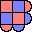

In [22]:
gen_normal_circuit(5, 2).diagram("interactive")

In [165]:

def show_stats(collected_stats, title):
    fig, ax = plt.subplots(1, 1)
    sinter.plot_error_rate(
        ax=ax,
        stats=collected_stats,
        x_func=lambda stats: stats.json_metadata['p'],
        group_func=lambda stats: stats.json_metadata['d'],
    )
    # ax.set_ylim(1e-4, 1e-0)
    # ax.set_xlim(5e-2, 5e-1)
    ax.loglog()
    ax.set_title(f"{title} Error Rates (Phenomenological Noise)")
    ax.set_xlabel("Phyical Error Rate")
    ax.set_ylabel("Logical Error Rate per Shot")
    ax.grid(which='major')
    ax.grid(which='minor')
    ax.legend()
    fig.set_dpi(120)  # Show it bigger

In [25]:
import matplotlib.pyplot as plt
import sinter

In [ ]:
tasks_nodefect = [
    sinter.Task(
        # circuit=gen_cut_circuit(d, d * 3),
        circuit=gen_cut_circuit(d, 2),
        # json_metadata={'d': d, 'p': noise},
        json_metadata={'d': d}
    )
    for d in [5]
    # for d in [3, 5, 7, 9, 11, 13]
    # for noise in [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05]
]

collected_stats_nodefect: List[sinter.TaskStats] = sinter.collect(
    num_workers=4,
    tasks=tasks_nodefect,
    decoders=['pymatching'],
    max_shots=100_000,
    max_errors=500
)

ValueError: Worker failed: traceback=Traceback (most recent call last):
  File "/Users/eli/dev/superstabilizer_demo/.venv/lib/python3.11/site-packages/sinter/_collection/_collection_worker_state.py", line 28, in _fill_in_task
    dem = circuit.detector_error_model(decompose_errors=True, approximate_disjoint_errors=True)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: The circuit contains non-deterministic detectors.

To make an SVG picture of the problem, you can use the python API like this:
    your_circuit.diagram('detslice-with-ops-svg', tick=range(93, 103), filter_coords=['D358', 'D359', ])
or the command line API like this:
    stim diagram --in your_circuit_file.stim --type detslice-with-ops-svg --tick 93:103 --filter_coords D358:D359 > output_image.svg

This was discovered while analyzing a Z-basis demolition measurement (MR) on:
    qubit 50 [coords (5, 8)]

The collapse anti-commuted with these detectors/observables:
    D358 [coords (6, 6, 15)]
    D359 [coords (6, 6, 15)]

The backward-propagating error sensitivity for D358 was:
    Z23 [coords (1, 5)]
    Z25 [coords (3, 5)]
    Z27 [coords (5, 5)]
    X28 [coords (5, 4)]
    Z34 [coords (1, 7)]
    Z35 [coords (2, 6)]
    Z36 [coords (3, 7)]
    Z38 [coords (5, 7)]
    X50 [coords (5, 8)]

The backward-propagating error sensitivity for D359 was:
    X25 [coords (3, 5)]
    X27 [coords (5, 5)]
    X28 [coords (5, 4)]
    Z29 [coords (7, 5)]
    X36 [coords (3, 7)]
    Z37 [coords (4, 6)]
    X38 [coords (5, 7)]
    Z40 [coords (7, 7)]
    X50 [coords (5, 8)]

Circuit stack trace:
    during TICK layer #99 of 106
    at instruction #84 [which is a REPEAT 14 block]
    at block's instruction #14 [which is MR 2 6 13 15 17 19 21 22 24 26 28 30 35 37 39 41 43 44 46 48 50 52 59 63]

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/eli/dev/superstabilizer_demo/.venv/lib/python3.11/site-packages/sinter/_collection/_collection_worker_state.py", line 31, in _fill_in_task
    dem = circuit.detector_error_model(approximate_disjoint_errors=True)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: The circuit contains non-deterministic detectors.

To make an SVG picture of the problem, you can use the python API like this:
    your_circuit.diagram('detslice-with-ops-svg', tick=range(93, 103), filter_coords=['D358', 'D359', ])
or the command line API like this:
    stim diagram --in your_circuit_file.stim --type detslice-with-ops-svg --tick 93:103 --filter_coords D358:D359 > output_image.svg

This was discovered while analyzing a Z-basis demolition measurement (MR) on:
    qubit 50 [coords (5, 8)]

The collapse anti-commuted with these detectors/observables:
    D358 [coords (6, 6, 15)]
    D359 [coords (6, 6, 15)]

The backward-propagating error sensitivity for D358 was:
    Z23 [coords (1, 5)]
    Z25 [coords (3, 5)]
    Z27 [coords (5, 5)]
    X28 [coords (5, 4)]
    Z34 [coords (1, 7)]
    Z35 [coords (2, 6)]
    Z36 [coords (3, 7)]
    Z38 [coords (5, 7)]
    X50 [coords (5, 8)]

The backward-propagating error sensitivity for D359 was:
    X25 [coords (3, 5)]
    X27 [coords (5, 5)]
    X28 [coords (5, 4)]
    Z29 [coords (7, 5)]
    X36 [coords (3, 7)]
    Z37 [coords (4, 6)]
    X38 [coords (5, 7)]
    Z40 [coords (7, 7)]
    X50 [coords (5, 8)]

Circuit stack trace:
    during TICK layer #99 of 106
    at instruction #84 [which is a REPEAT 14 block]
    at block's instruction #14 [which is MR 2 6 13 15 17 19 21 22 24 26 28 30 35 37 39 41 43 44 46 48 50 52 59 63]

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/eli/dev/superstabilizer_demo/.venv/lib/python3.11/site-packages/sinter/_collection/_collection_worker_state.py", line 243, in run_message_loop
    num_messages_processed = self.process_messages()
                             ^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/eli/dev/superstabilizer_demo/.venv/lib/python3.11/site-packages/sinter/_collection/_collection_worker_state.py", line 175, in process_messages
    self.compute_strong_id(new_task=message_body)
  File "/Users/eli/dev/superstabilizer_demo/.venv/lib/python3.11/site-packages/sinter/_collection/_collection_worker_state.py", line 133, in compute_strong_id
    strong_id = _fill_in_task(new_task).strong_id()
                ^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/eli/dev/superstabilizer_demo/.venv/lib/python3.11/site-packages/sinter/_collection/_collection_worker_state.py", line 33, in _fill_in_task
    dem = circuit.detector_error_model(approximate_disjoint_errors=True, flatten_loops=True)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: The circuit contains non-deterministic detectors.

To make an SVG picture of the problem, you can use the python API like this:
    your_circuit.diagram('detslice-with-ops-svg', tick=range(93, 103), filter_coords=['D358', 'D359', ])
or the command line API like this:
    stim diagram --in your_circuit_file.stim --type detslice-with-ops-svg --tick 93:103 --filter_coords D358:D359 > output_image.svg

This was discovered while analyzing a Z-basis demolition measurement (MR) on:
    qubit 50 [coords (5, 8)]

The collapse anti-commuted with these detectors/observables:
    D358 [coords (6, 6, 15)]
    D359 [coords (6, 6, 15)]

The backward-propagating error sensitivity for D358 was:
    Z23 [coords (1, 5)]
    Z25 [coords (3, 5)]
    Z27 [coords (5, 5)]
    X28 [coords (5, 4)]
    Z34 [coords (1, 7)]
    Z35 [coords (2, 6)]
    Z36 [coords (3, 7)]
    Z38 [coords (5, 7)]
    X50 [coords (5, 8)]

The backward-propagating error sensitivity for D359 was:
    X25 [coords (3, 5)]
    X27 [coords (5, 5)]
    X28 [coords (5, 4)]
    Z29 [coords (7, 5)]
    X36 [coords (3, 7)]
    Z37 [coords (4, 6)]
    X38 [coords (5, 7)]
    Z40 [coords (7, 7)]
    X50 [coords (5, 8)]

Circuit stack trace:
    during TICK layer #99 of 106
    at instruction #84 [which is a REPEAT 14 block]
    at block's instruction #14 [which is MR 2 6 13 15 17 19 21 22 24 26 28 30 35 37 39 41 43 44 46 48 50 52 59 63]
